## 라이브러리 가져오기

In [41]:
## 라이브러리 설치
# !pip install catboost

In [2]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np

## 그래프 관련
import matplotlib.pyplot as plt
import seaborn as sns

## 모델 관련
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

## 평가 관련
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, confusion_matrix

## 경고 문구 안 뜨게
import warnings
warnings.filterwarnings('ignore')

## 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터셋 불러오기 & 전처리

In [3]:
train = pd.read_csv('/content/drive/MyDrive/data/data/train.csv')
train.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [4]:
num_variables = ['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med', 
                 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt', 'funded_amnt_inv',
                 'total_rec_late_fee', 'term1', 'open_acc', 'installment', 'revol_util', 'out_prncp', 'out_prncp_inv', 'total_rec_int', 'fico_range_low', 'fico_range_high']

In [5]:
df_num = train[num_variables]

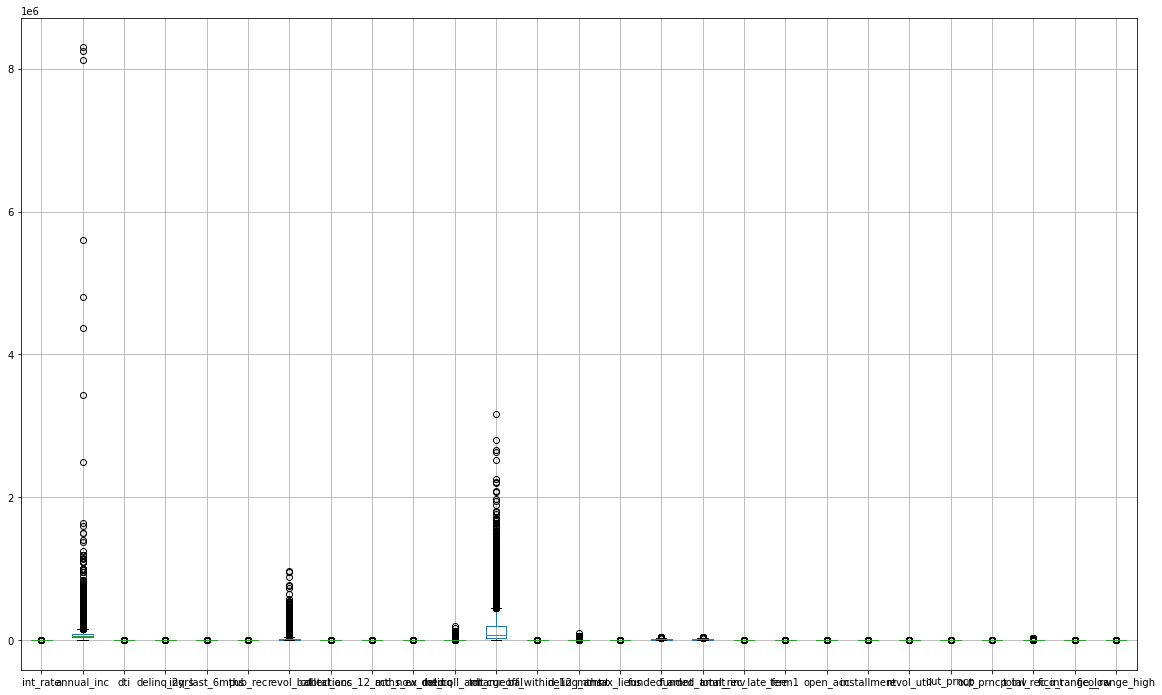

In [6]:
df_num.boxplot(figsize=(20, 12))

In [7]:
# 너무 튀는 이상치 제거
train = train[train['annual_inc']<8000000]

In [8]:
test = pd.read_csv('/content/drive/MyDrive/data/data/test.csv')
test.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,ID
0,0.1449,16380.0,26.08,0,0,1,3486,10,0,0,0,9214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8100,8100.0,0.00,1,4,278.78,0.311,0.0,0.0,460.40,700,704,0
1,0.1899,65000.0,13.97,0,0,0,25305,20,0,0,0,115612,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,20000,20000.0,0.00,0,10,518.71,0.885,0.0,0.0,4866.68,675,679,1
2,0.1049,53000.0,23.28,0,0,0,10910,21,0,0,0,33017,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,10000,10000.0,16.25,1,7,324.98,0.580,0.0,0.0,1451.06,675,679,2
3,0.1757,71800.0,30.32,0,0,0,42423,26,0,0,0,152515,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,27200,27200.0,0.00,0,16,684.36,0.701,0.0,0.0,7068.11,665,669,3
4,0.2020,50000.0,25.61,0,2,0,21703,24,0,0,0,135282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,22000,22000.0,0.00,0,13,585.32,0.622,0.0,0.0,7754.20,710,714,4


In [11]:
all = pd.concat([train, test])

In [12]:
# 상관관계 0.95 이상인 것들 하나씩 제거
all3 = all.drop(['funded_amnt','out_prncp_inv','fico_range_high'], axis=1)
all3.shape

(135813, 74)

In [13]:
all4 = all3

In [14]:
# 수치의 의미를 가진 컬럼인데 one-hot으로 되어있는거 의미에 맞게 변경
all4['emp_length'] = all4['emp_length1'] + all4['emp_length2']*2 + all4['emp_length3']*3 + all4['emp_length4']*4 + all4['emp_length5']*5 + all4['emp_length6']*6 + all4['emp_length7']*7 + all4['emp_length8']*8 + all4['emp_length9']*9 + all4['emp_length10']*10 + all4['emp_length11']*11 + all4['emp_length12']*12
all4['mths_since_last_delinq'] = all4['mths_since_last_delinq1'] + all4['mths_since_last_delinq2']*2 + all4['mths_since_last_delinq3']*3 + all4['mths_since_last_delinq4']*4 + all4['mths_since_last_delinq5']*5 + all4['mths_since_last_delinq6']*6 + all4['mths_since_last_delinq7']*7 + all4['mths_since_last_delinq8']*8 + all4['mths_since_last_delinq9']*9 + all4['mths_since_last_delinq10']*10 + all4['mths_since_last_delinq11']*11

In [15]:
all4 = all4.drop(columns=['emp_length1', 'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
                     'mths_since_last_delinq1', 'mths_since_last_delinq2', 'mths_since_last_delinq3', 'mths_since_last_delinq4', 'mths_since_last_delinq5', 'mths_since_last_delinq6', 'mths_since_last_delinq7', 'mths_since_last_delinq8', 'mths_since_last_delinq9', 'mths_since_last_delinq10', 'mths_since_last_delinq11'])

In [16]:
all4 = all4.drop(columns='ID')

In [17]:
train4 = all4[:len(train)]
test4 = all4[len(train):]

In [18]:
test4 = test4.drop(columns='depvar')

In [21]:
X = train4.drop('depvar', axis=1)
y = train4['depvar']

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [23]:
# 평가 함수
def f1_function(y_actual, y_pred_proba, threshold):
  
  result = []
  for i in range(len(y_pred_proba)):
    if y_pred_proba[i][1] >= threshold:
      result.append(1)
    else:
      result.append(0)

  return f1_score(y_actual, result)

In [24]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# train_scaled = scaler.fit_transform(X_train)
# train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns)
# train_scaled.head()

In [25]:
# valid_scaled = scaler.fit_transform(X_valid)
# valid_scaled = pd.DataFrame(valid_scaled, columns=X_train.columns)
# valid_scaled.head()

In [26]:
# test_scaled = scaler.fit_transform(test4)
# test_scaled = pd.DataFrame(test_scaled, columns=test4.columns)
# test_scaled.head()

## 모델링

In [27]:
# svc = SVC(random_state=42, probability=True)
# svc.fit(train_scaled, y_train)
# pred = svc.predict_proba(valid_scaled)
# f1_function(y_valid, pred, 0.25)

In [28]:
## 2시간 반이 걸려도 안 돌아감
# param_grid = {'C': [0.1, 10]}
# svc_grid = GridSearchCV(svc, param_grid)
# svc_grid.fit(train_scaled, y_train)
# svc_grid.best_params_

In [29]:
# from sklearn.neural_network import MLPClassifier

# mlp_grid = MLPClassifier(alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate='adaptive', max_iter=100)
# mlp_grid.fit(train_scaled, y_train)
# y_pred_proba = mlp_grid.predict_proba(valid_scaled)
# f1_function(y_valid, y_pred_proba, 0.3)

In [33]:
xgb_param1 = XGBClassifier(max_depth = 8,
                          n_estimators = 200,
                          eval_metric='auc')

xgb_param1.fit(X_train, y_train)
y_pred_proba = xgb_param1.predict_proba(X_valid)

f1_function(y_valid, y_pred_proba, 0.3)

0.6464594015707146

In [30]:
xgb_param2 = XGBClassifier(max_depth = 8,
                          n_estimators = 200,
                          eval_metric='auc',
                          colsample_bytree=0.8)  #tree_method='gpu_hist', predictor='gpu_predictor'

xgb_param2.fit(X_train, y_train)
y_pred_proba = xgb_param2.predict_proba(X_valid)

f1_function(y_valid, y_pred_proba, 0.3)

0.6466554534868676

In [22]:
xgb_param3 = XGBClassifier(max_depth = 9,
                          n_estimators = 230,
                          eval_metric='auc',
                          colsample_bytree=0.8)  #tree_method='gpu_hist', predictor='gpu_predictor'

xgb_param3.fit(X_train, y_train)
y_pred_proba = xgb_param3.predict_proba(X_valid)

f1_function(y_valid, y_pred_proba, 0.3)

0.6447258267057346

In [110]:
########################## 최종 사용 모델 ################################
lgbm_param = LGBMClassifier(random_state=42,
                            eval_metric='auc',
                            max_depth=8,
                            n_estimators=230,
                            colsample_bytree=0.8)

lgbm_param.fit(X_train, y_train)
y_pred_proba = lgbm_param.predict_proba(X_valid)

f1_function(y_valid, y_pred_proba, 0.3)

0.6372409428887835

In [34]:
# xgb = XGBClassifier(max_depth = 8, n_estimators = 200, eval_metric='auc', colsample_bytree=0.8)
# lgbm = LGBMClassifier(random_state=42, eval_metric='auc', max_depth=8, n_estimators=230, colsample_bytree=0.8)

# stacking = StackingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm)], final_estimator=LGBMClassifier())

In [ ]:
########################## 최종 사용 모델 ################################
xgb_param1 = XGBClassifier(max_depth = 8,
                          n_estimators = 200,
                          eval_metric='auc')
xgb_param2 = XGBClassifier(max_depth = 8,
                          n_estimators = 200,
                          eval_metric='auc',
                          colsample_bytree=0.8)
xgb_param3 = XGBClassifier(max_depth = 9,
                          n_estimators = 230,
                          eval_metric='auc',
                          colsample_bytree=0.8)

stacking = StackingClassifier(estimators=[('xgb_param1', xgb_param1), ('xgb_param2', xgb_param2), ('xgb_param3', xgb_param3)], final_estimator=LGBMClassifier())

In [37]:
# cbc = CatBoostClassifier(task_type='GPU', verbose=30, learning_rate=0.01, iterations=10000)
# cbc.fit(X_train, y_train, eval_set=(X_valid,y_valid), early_stopping_rounds=30)

In [38]:
# y_pred_proba = cbc.predict_proba(X_valid)
# f1_function(y_valid, y_pred_proba, 0.3)

In [39]:
# xgb = XGBClassifier(max_depth = 8, n_estimators = 200, eval_metric='auc', tree_method='gpu_hist', predictor='gpu_predictor')
# cbc = CatBoostClassifier(task_type='GPU', verbose=30, learning_rate=0.01, iterations=5000)
# lgbm = LGBMClassifier(random_state=42, eval_metric='auc', max_depth=8, n_estimators=230, tree_method='gpu_hist', predictor='gpu_predictor')

In [40]:
# stacking = StackingClassifier(estimators=[('xgb', xgb), ('cbc', cbc), ('lgbm', lgbm)], final_estimator=LGBMClassifier())
# stacking.fit(X, y)

In [35]:
sub = pd.read_csv('/content/drive/MyDrive/data/data/sample_submission.csv')
sub

,ID,answer
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
35811,35811,0
35812,35812,0
35813,35813,0
35814,35814,0


In [36]:
stacking.fit(X, y)
y_proba = stacking.predict_proba(test4)

result = []
for i in range(len(y_proba)):
  if y_proba[i][1] >= 0.3:
    result.append(1)
  else:
    result.append(0)

sub['answer'] = result

sub.to_csv('/content/drive/MyDrive/data/data/prediction24.csv', index=False)